In [1]:
import numpy as np
import pandas as pd
import itertools

import scipy
from scipy import stats
from statsmodels.stats.weightstats import *

from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [2]:
data = pd.read_csv('ab_browser_test.csv')
data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


В данном задании вам нужно будет

- проанализировать АБ тест, проведенный на реальных пользователях Яндекса
- подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
- определить характер этих изменений и практическую значимость вводимого изменения
- понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

Описание данных:

- userID: уникальный идентификатор пользователя
- browser: браузер, который использовал userID
- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
- n_clicks: количество кликов, которые пользоваль совершил за n_queries
- n_queries: количество запросов, который совершил userID, пользуясь браузером browser
- n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [3]:
data['id'] =  map(lambda x, y: str(x) + '-'+ str(y) ,data['userID'], data['browser'])

In [4]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,id
0,1,Browser #2,exp,23,32,19,1-Browser #2
1,3,Browser #4,exp,3,4,2,3-Browser #4
2,5,Browser #4,exp,29,35,16,5-Browser #4
3,6,Browser #4,control,12,6,0,6-Browser #4
4,7,Browser #4,exp,54,68,30,7-Browser #4


Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [5]:
pd.crosstab(data.slot,data.n_clicks.sum())
a = data.groupby('slot')['n_clicks'].sum()[0]
b = data.groupby('slot')['n_clicks'].sum()[1]
print b,a, ((float(b)/float(a)) * 100) - 100

3261823 3210027 1.61356898244


In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
scores_1 = map(np.median, get_bootstrap_samples(data[data.slot=='exp'].n_clicks.values, 1000))
scores_2 = map(np.median, get_bootstrap_samples(data[data.slot=='control'].n_clicks.values, 1000))

In [8]:
print stat_intervals(scores_1, 0.05)
print stat_intervals(scores_2, 0.05)
print (stat_intervals(scores_1, 0.05) - stat_intervals(scores_2, 0.05))

[ 5.  5.]
[ 4.  4.]
[ 1.  1.]


In [9]:
scores_1 = map(np.mean, get_bootstrap_samples(data[data.slot=='exp'].n_clicks.values, 1000))
scores_2 = map(np.mean, get_bootstrap_samples(data[data.slot=='control'].n_clicks.values, 1000))

In [10]:
print stat_intervals(scores_1, 0.05)
print stat_intervals(scores_2, 0.05)
print (stat_intervals(scores_1, 0.05) - stat_intervals(scores_2, 0.05))

[ 11.51314253  11.66236594]
[ 11.2097514   11.35509227]
[ 0.30339113  0.30727367]


In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
print data[data.slot=='exp'].n_clicks.values.mean()
print data[data.slot=='control'].n_clicks.values.mean()

11.5840009944
11.2809062603


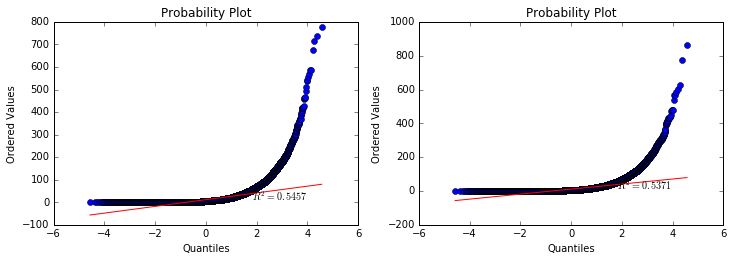

In [58]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(data[data.slot=='exp'].n_clicks, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(data[data.slot=='control'].n_clicks, dist="norm", plot=pylab)
pylab.show()

#### TRUE
Для проверки гипотезы о равенстве средних категорически нельзя использовать t-критерий Стьюдента ни при каком размере выборки, потому что количество кликов, которые мы исследуем, больше походят на распределение Пуассона, которое сильно отличается от нормального. 

In [59]:
np.random.seed(0)
n_boot_samples = 500
scores_3 = map(np.mean, get_bootstrap_samples(data[data.slot=='control'].n_clicks.values, n_boot_samples))

In [64]:
scores_4 = map(scipy.stats.chisquare, get_bootstrap_samples(data[data.slot=='control'].n_clicks.values, n_boot_samples))


In [65]:
scores_4 = map(lambda x: x[0], scores_4 )

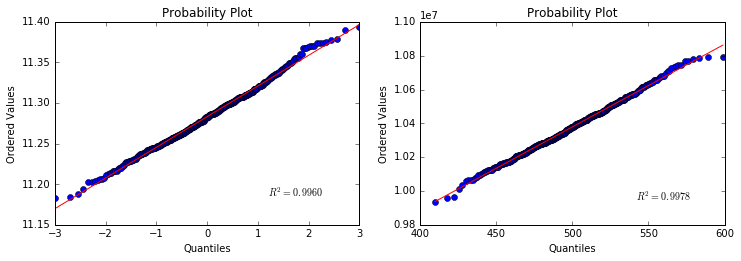

In [66]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(scores_3, dist="norm", plot=pylab)

pylab.subplot(2,2,2)
stats.probplot(scores_4, dist="chi2",sparams = 499, plot=pylab)
pylab.show()

In [73]:
stats.mannwhitneyu(data[data['slot']=='control'].n_clicks, data[data['slot']=='exp'].n_clicks)

MannwhitneyuResult(statistic=38940590204.0, pvalue=2.2563433887431387e-74)

In [136]:
pivot = data.pivot_table(index="slot", 
     values="n_clicks", columns="browser", aggfunc = len, fill_value=0)

In [137]:
pivot

browser,Browser #14,Browser #17,Browser #2,Browser #20,Browser #22,Browser #4
slot,,,,,,
control,44903,16354,55793,16998,71825,78681
exp,44220,16253,54944,16931,71080,78152


In [138]:
pt['Browser #14'][0]

44903

In [147]:
browsers = [14,17,2,20,22,4]
p_values = np.array([])

for n in browsers:
    sts, p =  scipy.stats.mannwhitneyu(
        data[(data.browser=='Browser #' + str(n)) & (data.slot=='exp')].n_clicks.values,
        data[(data.browser=='Browser #' + str(n)) & (data.slot=='control')].n_clicks.values,
        alternative='two-sided')
    p_values = np.append(p_values,p)
    

In [148]:
print p_values

[ 0.          0.07537991  0.05579979  0.90754133  0.51616653  0.81556889]


In [149]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [150]:
reject, p_corrected, a1, a2 = multipletests(p_values, 
                                            alpha = 0.05, 
                                            method = 'holm')

In [151]:
p_corrected

array([ 0.        ,  0.30151962,  0.27899895,  1.        ,  1.        ,  1.        ])

In [196]:
reject

array([ True, False, False, False, False, False], dtype=bool)

In [227]:
browsers = [14,17,2,20,22,4]
percent_c = np.array([])
percent_e = np.array([])

for n in browsers:
    a = float(data[(data.browser=='Browser #' + str(n)) & (data.slot=='control')].n_nonclk_queries.sum())
    b = float(data[(data.browser=='Browser #' + str(n)) & (data.slot=='control')].n_queries.sum())
    percent_c = np.append(percent_c,100*(a/b))
print percent_c 

[ 57.59041136  36.29936675  45.96274718  40.54048474  40.59397659
  46.97092964]


In [228]:
for n in browsers:
    a = float(data[(data.browser=='Browser #' + str(n)) & (data.slot=='exp')].n_nonclk_queries.sum())
    b = float(data[(data.browser=='Browser #' + str(n)) & (data.slot=='exp')].n_queries.sum())
    percent_e = np.append(percent_e,100*(a/b))
print percent_e

[ 43.75561736  36.93741285  44.98274695  38.97737648  39.85394722
  45.1429419 ]
